<center><h1>ECSE 415 Course Project - Counting People in a
Shopping Mall</h1>
<h4>SVM with HoG Features (Part 2)</h4></center>

<h3>Team Members:</h3>
<center>
Lawrence Zhang, 260664442<br>
Yinuo Wang, 260766084<br>
Fei Peng, 260712440<br>
Yukai Zhang, 260710915<br>
</center>

# Install detectron2

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

%cd '/content/gdrive/My Drive/ECSE_415_Project/frames/'

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/.shortcut-targets-by-id/1oHyE7rxbw-bo9WbZ2w2kPnRlpwBVEAKl/ECSE_415_Project/frames


In [ ]:
# install dependencies: 
!pip install pyyaml==5.1
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())
!gcc --version
# opencv is pre-installed on colab

1.7.0+cu101 True
gcc (Ubuntu 7.5.0-3ubuntu1~18.04) 7.5.0
Copyright (C) 2017 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.



In [ ]:
# install detectron2: (Colab has CUDA 10.1 + torch 1.7)
# See https://detectron2.readthedocs.io/tutorials/install.html for instructions
import torch
assert torch.__version__.startswith("1.7")
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.7/index.html
# exit(0)  # After installation, you need to "restart runtime" in Colab. This line can also restart runtime

Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.7/index.html


In [ ]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

** fvcore version of PathManager will be deprecated soon. **
** Please migrate to the version in iopath repo. **
https://github.com/facebookresearch/iopath 

** fvcore version of PathManager will be deprecated soon. **
** Please migrate to the version in iopath repo. **
https://github.com/facebookresearch/iopath 



# Run a pre-trained detectron2 model

We first download an image from the COCO dataset:

Then, we create a detectron2 config and a detectron2 `DefaultPredictor` to run inference on this image.

In [ ]:
import os
import random

In [ ]:
path = "./"
files = sorted(os.listdir(path))
count_people = []
positive_patches = []
for file in iter(files):
    im = cv2.imread(path + file)
    # im = cv2.imread("./seq_002000.jpg")
    cfg = get_cfg()
    # add project-specific config (e.g., TensorMask) here if you're not running a model in detectron2's core library
    cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
    cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # set threshold for this model
    # Find a model from detectron2's model zoo. You can use the https://dl.fbaipublicfiles... url as well
    cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
    predictor = DefaultPredictor(cfg)
    outputs = predictor(im)
    boxes = outputs["instances"].pred_boxes[outputs["instances"].pred_classes == 0]
    count_people.append(len(boxes))
    positive_patches.append(boxes)
    print("Frame: {}, number of people: {}".format(file, len(boxes)))

model_final_f10217.pkl: 178MB [00:16, 11.0MB/s]                           
/usr/local/lib/python3.6/dist-packages/detectron2/modeling/roi_heads/fast_rcnn.py:124: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:882.)
  filter_inds = filter_mask.nonzero()


Frame: seq_000001.jpg, number of people: 25
Frame: seq_000002.jpg, number of people: 32
Frame: seq_000003.jpg, number of people: 32
Frame: seq_000004.jpg, number of people: 34
Frame: seq_000005.jpg, number of people: 33
Frame: seq_000006.jpg, number of people: 25
Frame: seq_000007.jpg, number of people: 30
Frame: seq_000008.jpg, number of people: 31
Frame: seq_000009.jpg, number of people: 17
Frame: seq_000010.jpg, number of people: 22
Frame: seq_000011.jpg, number of people: 14
Frame: seq_000012.jpg, number of people: 15
Frame: seq_000013.jpg, number of people: 18
Frame: seq_000014.jpg, number of people: 18
Frame: seq_000015.jpg, number of people: 11
Frame: seq_000016.jpg, number of people: 15
Frame: seq_000017.jpg, number of people: 11
Frame: seq_000018.jpg, number of people: 21
Frame: seq_000019.jpg, number of people: 25
Frame: seq_000020.jpg, number of people: 25
Frame: seq_000021.jpg, number of people: 25
Frame: seq_000022.jpg, number of people: 18
Frame: seq_000023.jpg, number of

## Generate Positive Data

In [ ]:
numpy_patches = []
for i, patches in enumerate(positive_patches):
    numpy_patches.append(patches.tensor.cpu().numpy().squeeze())

[202.06197  83.61165 221.10777 143.51595]


## Generate Negative Data

In [ ]:
x_coor_list = np.linspace(0, 640, num=80, endpoint=False) # horizontal
y_coor_list = np.linspace(0, 480, num=20, endpoint=False) # vertical

coor_samples = []

# for people_box in random.sample(numpy_patches, 200):
for people_box in numpy_patches:

    coor_list = []

    for i, y in enumerate(y_coor_list):
        for j, x in enumerate(x_coor_list):
            x_check = len(people_box[people_box[:,2]<x])+len(people_box[people_box[:,0]>(x+48)])
            y_check = len(people_box[people_box[:,3]<y])+len(people_box[people_box[:,1]>(y+144)])
            if(x_check == people_box.shape[0] or y_check == people_box.shape[0]):
                coor_list.append([x,y,(x+48),(y+144)])

    for i, y in enumerate(y_coor_list):
        for j, x in enumerate(x_coor_list):
            x_check = len(people_box[people_box[:,2]<x])+len(people_box[people_box[:,0]>(x+32)])
            y_check = len(people_box[people_box[:,3]<y])+len(people_box[people_box[:,1]>(y+96)])
            if(x_check == people_box.shape[0] or y_check == people_box.shape[0]):
                coor_list.append([x,y,(x+32),(y+96)])

    for i, y in enumerate(y_coor_list):
        for j, x in enumerate(x_coor_list):
            x_check = len(people_box[people_box[:,2]<x])+len(people_box[people_box[:,0]>(x+24)])
            y_check = len(people_box[people_box[:,3]<y])+len(people_box[people_box[:,1]>(y+72)])
            if(x_check == people_box.shape[0] or y_check == people_box.shape[0]):
                coor_list.append([x,y,(x+32),(y+96)])

    for i, y in enumerate(y_coor_list):
        for j, x in enumerate(x_coor_list):
            x_check = len(people_box[people_box[:,2]<x])+len(people_box[people_box[:,0]>(x+16)])
            y_check = len(people_box[people_box[:,3]<y])+len(people_box[people_box[:,1]>(y+48)])
            if(x_check == people_box.shape[0] or y_check == people_box.shape[0]):
                coor_list.append([x,y,(x+16),(y+48)])

    coor_samples.append(random.sample(coor_list, min(len(people_box),len(coor_list))))

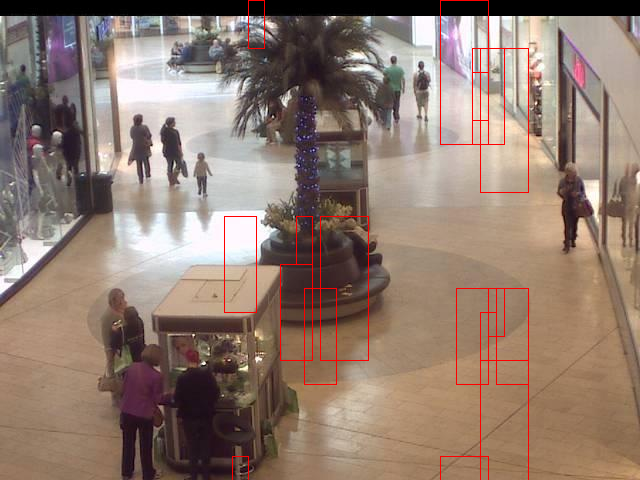

In [ ]:
image = cv2.imread(path + files[526])
output = image.copy()
for coor_sample in iter(coor_samples[526]):
    output = cv2.rectangle(output,(int(coor_sample[0]), int(coor_sample[1])),(int(coor_sample[2]), int(coor_sample[3])),(0,0,255),1)
cv2_imshow(output)

## Dump Data

In [ ]:
from numpy import asarray
from numpy import save
save('../Yukai/Data_Dump/numpy_patches.npy', np.asarray(numpy_patches))
save('../Yukai/Data_Dump/count_people.npy', np.asarray(count_people))
save('../Yukai/Data_Dump/coor_samples.npy', np.asarray(coor_samples))

## Load Data

In [ ]:
from numpy import load
numpy_patches = load('../Yukai/Data_Dump/numpy_patches.npy', allow_pickle=True)
count_people = load('../Yukai/Data_Dump/count_people.npy', allow_pickle=True)
coor_samples = load('../Yukai/Data_Dump/coor_samples.npy', allow_pickle=True)

In [ ]:
path = "./"
files = sorted(os.listdir(path))

# HoG Feature

In [ ]:
def compute_hog(images):
    features = []

    img_size = (24, 8) # h x w in pixels
    cell_size = (3, 1)  # h x w in pixels
    block_size = (4, 4)  # h x w in cells
    nbins = 4  # number of orientation bins

    # create HoG Object
    # winSize is the size of the image cropped to multiple of the cell size
    # all arguments should be given in terms of number of pixels
    hog = cv2.HOGDescriptor(_winSize=(img_size[1] // cell_size[1] * cell_size[1],
                                      img_size[0] // cell_size[0] * cell_size[0]),
                            _blockSize=(block_size[1] * cell_size[1],
                                        block_size[0] * cell_size[0]),
                            _blockStride=(cell_size[1], cell_size[0]),
                            _cellSize=(cell_size[1], cell_size[0]),
                            _nbins=nbins)
    
    for image in images:
        # resize the images
        resized = cv2.resize(image, img_size, interpolation=cv2.INTER_AREA)
    
        features.append(hog.compute(resized.reshape(img_size).astype(np.uint8)).reshape(1, -1))
    
    features = np.vstack(features)
    return features

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
num_img = np.arange(0,2000)
path = "./"
files = sorted(os.listdir(path))
sub_list = []
for i in random.sample(list(num_img), 200):
    im = cv2.imread(path + files[i], cv2.IMREAD_GRAYSCALE)
    for coor in numpy_patches[i]:
        coor = coor.astype(int)
        sub_list.append(im[coor[1]:coor[3],coor[0]:coor[2]])

pos_hog = compute_hog(sub_list)

In [ ]:
print(len(pos_hog))

4789


In [ ]:
num_img = np.arange(0,2000)
path = "./"
files = sorted(os.listdir(path))
sub_list = []
for i in random.sample(list(num_img), 200):
    im = cv2.imread(path + files[i], cv2.IMREAD_GRAYSCALE)
    for coor in coor_samples[i]:
        coor = np.asarray(coor, dtype=int)
        sub_list.append(im[coor[1]:coor[3],coor[0]:coor[2]])

neg_hog = compute_hog(sub_list)

In [ ]:
print(len(neg_hog))

4772


# Train SVC

In [ ]:
from sklearn import svm

In [ ]:
clf = svm.SVC(gamma='auto', kernel='linear')
train_X = np.concatenate((np.asarray(pos_hog), np.asarray(neg_hog)))
train_y = np.concatenate((np.ones(len(pos_hog)),np.zeros(len(neg_hog))))
# clf.fit(train_X, train_y)

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(train_X, train_y, test_size=0.2, random_state=0)
clf.fit(X_train, y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

## Dump clf (SVM)

In [ ]:
from sklearn.externals import joblib
joblib.dump(clf, '../Data/svc.npy')

/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


['../Yukai/Data_Dump/svc.npy']

## Load clf (SVM)

In [ ]:
clf_load = joblib.load('../Data/svc.npy')

# Pyramid Sliding Window

In [ ]:
from sklearn.metrics import accuracy_score
print(X_test.shape)
y_pred = clf.predict(X_test)
accuracy_score(y_test, y_pred)

(1913, 1600)


0.882906429691584

In [ ]:
def sliding_window(image, step_size, window_size):
    for y in range(0, image.shape[0], step_size):
        for x in range(0, image.shape[1], step_size):
            yield (x, y, image[y: y + window_size[0], x: x + window_size[1]])

In [ ]:
def pyramid(image, scale=1.5, min_size=(145, 200)):
    yield image
    while True:
        h = int(image.shape[0] / scale)
        w = int(image.shape[1] / scale)
        image = cv2.resize(image, (h, w), interpolation=cv2.INTER_AREA)
        if image.shape[0] < min_size[0] or image.shape[1] < min_size[1]:
            break
        yield image

# Non-Maximum Suppression and People Counting

In [ ]:
from time import time
from imutils.object_detection import non_max_suppression
from sklearn.metrics import mean_squared_error

In [ ]:
def svm_count(img_no, det_thresh):
    tic = time()
    image = cv2.imread(path + files[img_no], cv2.IMREAD_GRAYSCALE)
    win_w = 16
    win_h = 48
    pred = 0
    svm_boxes = []
    sc = []
    frac = 1
    for resized in pyramid(image, scale=1.5):

        for (x, y, window) in sliding_window(resized, step_size=16, window_size=(win_h, win_w)):
            if window.shape[0] != win_h or window.shape[1] != win_w:
                continue
            clone = window.copy()
            clone = (clone,)
            hog_clone = compute_hog(clone)
            pred = clf.predict(hog_clone)
            if pred:
                if clf.decision_function(hog_clone) > det_thresh:
                    sc.append(clf.decision_function(hog_clone))
                    svm_boxes.append([int(x*frac), int(y*frac), int((x+win_w)*frac), int((y+win_h)*frac)])
        frac *= 1.5

    # people counting with non-maximum suppression
    pick = non_max_suppression(np.asarray(svm_boxes), probs=np.asarray(sc).squeeze(), overlapThresh=0.1)
    # return len(pick)
    return pick

# Example of People Detection

In [ ]:
svm_people_count = svm_count(1465, 1.6)

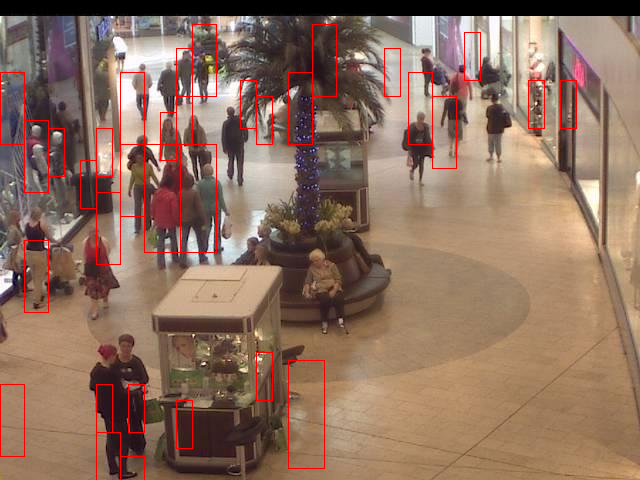

In [ ]:
image = cv2.imread(path + files[1465])
output = image.copy()
for svm_box in iter(svm_people_count):
    output = cv2.rectangle(output,(int(svm_box[0]), int(svm_box[1])),(int(svm_box[2]), int(svm_box[3])),(0,0,255),1)
cv2_imshow(output)

# IoU Calculation

In [ ]:
IoU = []
HoG_count = []
for i in range(2000):
    svm_image_mask = np.zeros((640, 480), dtype=np.int8)
    fb_image_mask = np.zeros((640, 480), dtype=np.int8)
    svm_count_peoples = svm_count(i, 1.8)
    HoG_count.append(len(svm_count_peoples))
    for svm_count_people in svm_count_peoples:
        svm_image_mask[svm_count_people[0]:svm_count_people[2], svm_count_people[1]:svm_count_people[3]] = 1
    for fb_count_people in numpy_patches[i]:
        fb_count_people = fb_count_people.astype(int)
        fb_image_mask[fb_count_people[0]:fb_count_people[2], fb_count_people[1]:fb_count_people[3]] = 1
    sum_image_mask = (fb_image_mask + svm_image_mask).reshape(-1)
    IoU.append(np.sum(sum_image_mask == 2) / np.sum(sum_image_mask > 0))
    print("Image: {}, IoU: {}".format(i+1, IoU[-1]))
print(np.mean(IoU))

Image: 1, IoU: 0.05876327175000301
Image: 2, IoU: 0.2050681566521147
Image: 3, IoU: 0.15183317246910727
Image: 4, IoU: 0.15186332676893743
Image: 5, IoU: 0.12845712652827956
Image: 6, IoU: 0.1358288770053476
Image: 7, IoU: 0.13449515568825787
Image: 8, IoU: 0.20561151261891758
Image: 9, IoU: 0.14980300251341622
Image: 10, IoU: 0.23385246719197503
Image: 11, IoU: 0.1161217587373168
Image: 12, IoU: 0.07748681100952472
Image: 13, IoU: 0.22296489512009565
Image: 14, IoU: 0.12062003220282669
Image: 15, IoU: 0.05332600329851567
Image: 16, IoU: 0.11047979797979798
Image: 17, IoU: 0.11506453609665512
Image: 18, IoU: 0.19867135056171958
Image: 19, IoU: 0.2509000025899355
Image: 20, IoU: 0.1796175174178871
Image: 21, IoU: 0.2086497193793331
Image: 22, IoU: 0.21973983978834424
Image: 23, IoU: 0.25124479634315566
Image: 24, IoU: 0.08692677338255418
Image: 25, IoU: 0.15413685221323917
Image: 26, IoU: 0.2580010757748941
Image: 27, IoU: 0.14005399235410287
Image: 28, IoU: 0.18461692238492677
Image: 2

In [ ]:
import pandas as pd
result = {'id': np.arange(1,2001), 'count': HoG_count}
df = pd.DataFrame(data=result)
df.to_csv('../result_HoG.csv', index=False)
from google.colab import files
files.download('../result_HoG.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>